# HRV Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import peakutils
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_time_domain_features, get_frequency_domain_features, plot_psd
from scipy.signal import butter, lfilter, find_peaks
from scipy.stats import zscore
from pyhrv import nonlinear
from pyentrp import entropy as ent

results = {}

## Background

The human cardiovascular system is thoroughly challenged during spaceflight. Factors such as radiation exposure,
altered gravity, and acceleration associated with launch and landing, can all have impact on cardiovascular
health and function. On returning from space and exposure to normal gravitational conditions, the challenged
human cardiovascular system often presents with the following problems: cardiac atrophy, decreased
baroreflex sensitivity, altered autonomic function, and oxidative damage, which can lead to orthostatic
intolerance and a reduction in work capacity.

Heart rate variability (HRV) analysis of ECG data allow for a quick and accurate method to assess cardiovascular health in astronauts exposed to hypergravity conditions during spaceflight launch. This research project aims to answer NASA's Human Research Program (HRP) goal to optimize crew health and performance and address cardiovascular risks associated with hypergravity.
   
Our research will focus on detecting cardiovascular changes in response to hypergravity by analyzing ECG recordings taken from mice exposed to 4 weeks of centrifugation. Specifically, we will be extracting and analyzing heart rate variability measures that are present in three different realms: 1) time-domain analysis 2) frequency-domain analysis, and 3) non-linearity measures analysis.

*This Jupyter notebook establishes a proof-of-concept heart rate variability analysis can be done with efficiency and reproducability.* Here, we show an analysis pipeline using an open-source database from PhysioNet's MIT-BIH Normal Sinus Rhythm Database (https://physionet.org/physiobank/database/nsrdb/).

## Data Collection

The MIT-BIH Normal Sinus Rhythm Database includes 18 long-term ECG recordings of subjects referred to the Arrhythmia Laboratory at Boston's Beth Israel Hospital (now the Beth Israel Deaconess Medical Center). Subjects included in this database were found to have had no significant arrhythmias; they include 5 men, aged 26 to 45, and 13 women, aged 20 to 50 [1] . The first five minutes of ECG data were selected, because five minutes is the length of time traditionally required for short-term HRV analysis.
   
## Data Preperation

Refer to `Convert-From-PhysioNet.ipynb` to prepare the raw .csv files. 
   
## Output Overview

|Name   | Object Type  | Domain  | Description  |
|---|---|---|---|
|SDNN   | float  | Time  | Standard deviation of the IBI of normal sinus beats   |
|pNN50   | float  | Time  | Percentage of adjacent N-N intervals that differ from each other by more than 50 ms  |
|RMSSD   | float  | Time  | Root mean square of successive differences between normal heart beats  |
|HR_diff   | float  | Time  | the average difference between the highest and lowest heart rates during each respiratory cycle (HR Max - HR Min) |
|VLF   | float  | Frequency  | Very low frequency band (0.0033-0.04 Hz in humans)  |
|LF   | float  | Frequency  | Low frequency (LF) band (0.04-0.15 Hz in humans) |
|HF   | float  | Frequency  | High frequency (HF) band (0.15-0.40 Hz in humans)  |
|LHFratio   | float  | Frequency  | The ratio of LF to HF power |
|S   | float  | Nonlinear  | The area of the ellipse |
|SD1   | float  | Nonlinear  | The width of the ellipse  |
|SD2   | float  | Nonlinear  | The length of the ellipse  |
|SDratio   | float  | Nonlinear  | The ratio of SD1/SD2 that measures the unpredictability in a time series  |
|SampEn   | float  | Nonlinear  | Sample entropy: quantification of the regularity and complexity of physiological time-series signals  |
|ShanEn   | float  | Nonlinear  | Shannon entropy: general measure of uncertainty  |

## Data Cleaning

In [2]:
df = pd.read_csv('raw/human/PhysioNet-nsrdb/16272-128.csv',
            sep = ',', skiprows = 6, names = ['Time', 'ECG mV'])

In [3]:
fs = 128 # sampling rate, obtained from `p_signal` key in `Convert-From-PhysioNet.ipynb`

data = df[0:int((300/(1/fs)))] # Select only the first five minutes of data
# 300 seconds / (1/Sampling rate)

### Data Pre-processing

#### Baseline Correction Through Polynomial Fitting
Baseline Correction through polynomial fitting is necessary in the event that your raw data file has baseline drift. See
https://peakutils.readthedocs.io/en/latest/reference.html#module-peakutils.baseline for more documentation.

In [4]:
polynomial = 3 # default is 3
baseline_corr = peakutils.baseline(data['ECG mV'], polynomial)
data = data.assign(Detrend=data['ECG mV']-baseline_corr) #add new columns to dataframe

#### Bandpass Filter Application
Butterworth Bandpass Digital Filter - application of a digital filter can help reduce noise in the raw signal. See 
https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html for more information.

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
# Digitally bandpass‐filter between 0.1 and 50 Hz.
data = data.assign(ECG_Bandpass=butter_bandpass_filter(data['ECG mV'].values, .1, 60, fs))

#### Amplify R peak by template matching to a partial sine wave
Amplification of R peaks by template matching - use of a partial sine wave to amplify the ECG peaks. See https://en.wikipedia.org/wiki/Template_matching for more information.

In [7]:
# Use Sine Wave to amplify QRS complex
t = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15) # linear spaced vector between 0.5 pi and 1.5 pi 
qrs_filter = np.sin(t) # create sine wave

# Compute cross correlation between ecg and qrs filter
similarity = np.correlate(data['ECG_Bandpass'], qrs_filter, mode='same')
data['ECG normalized'] = similarity

#### Plot data with peaks

In [8]:
%matplotlib qt

# Peak Detection
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
y = data['ECG normalized']
x = data['Time']
ind = find_peaks(data['ECG normalized'], height = 1, distance = 75)[0]
# distance in sample recorded

plt.xlabel('Time (s)')
plt.ylabel('ECG (normalized)')
plt.plot(x, y, '--')
plt.plot(x[ind], y[ind], 'r+', ms=5, mew=2,
         label='{} peaks'.format(len(ind)))
plt.legend()
plt.title('ECG over Time')
plt.show()

![][logo]

[logo]: img/ecg_normalized.png 

### ECG Cleaning

To account for physiological artifacts and other types of artifacts, we first take all R-R intervals and replace all outliers (at least 3 standard deviations away) with the median of the dataset. Then, we detect and remove ectopic beats, effectively change R-R intervals into N-N intervals. 
Interpolation of missing data was performed linearally. See [2] for more details.

In [9]:
rr_ind = np.diff(ind)
rr = rr_ind.copy()
z_score = zscore(rr)
rr_ind[np.abs(z_score) > 3] = np.median(rr)
print('{} outliers were replaced with the median'.format(sum(map(lambda x,y: bool(x-y),rr,rr_ind))))
ect_ind = remove_ectopic_beats(rr_ind)
nn_ind = interpolate_nan_values(rr_intervals=ect_ind)

3 outliers were replaced with the median
0 ectopic beat(s) have been deleted with malik rule.


In [10]:
time_domain_features = get_time_domain_features(nn_ind)

## Time Domain Measures

In [11]:
time_dict = get_time_domain_features(nn_ind)

results['SDNN'] = time_dict['sdnn']
results['pNN50'] = time_dict['pnni_20']
results['RMSSD'] = time_dict['rmssd']
results['HRdiff'] = time_dict['max_hr'] - time_dict['min_hr']

## Frequency Domain Measures
Apply a Fast Fourier Transform (FFT) to the time-series data to obtain frequency domain measures.

In [12]:
freq_dict = get_frequency_domain_features(nn_ind)

results['VLF'] = freq_dict['vlf']
results['LF'] = freq_dict['lf']
results['HF'] = freq_dict['hf']
results['LHFratio'] = freq_dict['lf_hf_ratio']

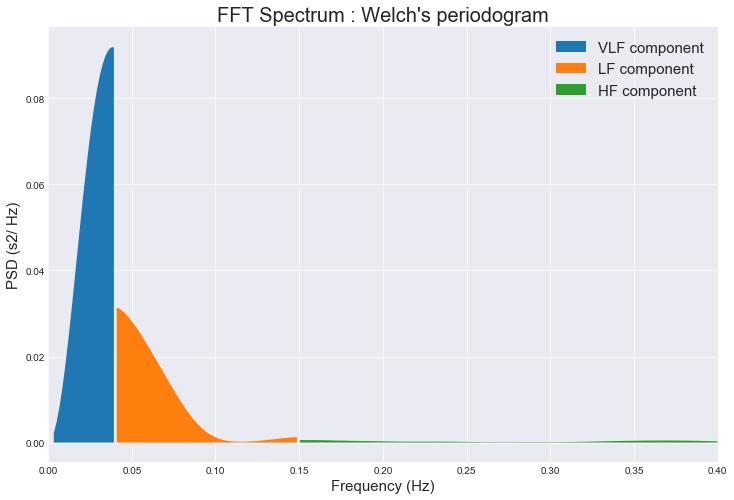

In [17]:
%matplotlib inline

plot_psd(nn_ind, method="welch")

## Nonlinear Domain Measures

#### Poincaré Plot

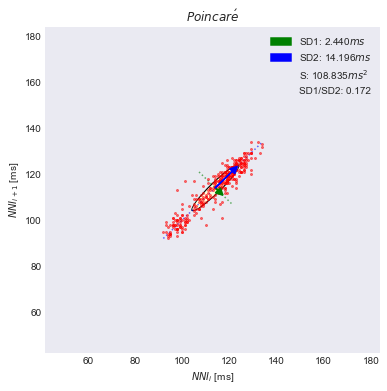

In [14]:
%matplotlib inline

plot, results['SD1'], results['SD2'], results['SDratio'], results['S'] = nonlinear.poincare(nn_ind)

#### Entropies

In [15]:
results['SampEn']= np.mean(ent.sample_entropy(nn_ind, len(t), 0.2 * np.std(nn_ind))) # t = use the length of template vector
results['ShanEn'] = ent.shannon_entropy(nn_ind)

# Output

In [16]:
pd.DataFrame.from_dict(results, orient='index', columns = ['Value'])

,Value
SDNN,10.198087
pNN50,0.000000
RMSSD,3.451471
HRdiff,204.412719
VLF,42.651313
LF,61.070408
HF,10.179774
LHFratio,5.999191
SD1,2.440290
SD2,14.196417


**References**

1) Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13).

2) Kamath M. V., Fallen E. L. (1995). Correction of the heart rate variability signal for ectopics and missing beats, in Heart Rate Variability, eds M. Malik, Camm A. J., editors. (Armonk, NY: Futura Publishing Co. Inc.), 75–85.